In [7]:
import sys
sys.path.append('../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_forward, run_rc_sim, UniformPrior, linear_scale_array,
                   get_dataset_psd, get_dataset_peaks, load_posterior)
import dill
from sbi import utils as sbi_utils
import pandas as pd
from scipy.stats import wasserstein_distance

sns.set()
sns.set_style("white")

device = 'cpu'
data_path = '../data/rc_circuit'

with open(f'{data_path}/posteriors/rc_posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/rc_posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation

t_vec = np.linspace(0, tstop, np.round(tstop/dt).astype(int))

In [19]:
num_samples = 10 # number of samples drawn from posterior for validation
x_cond, theta_cond = np.load(f'{data_path}/sbi_sims/x_grid.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')
x_cond_peak = get_dataset_peaks(x_cond)

ground_truth_idx = np.repeat(range(x_cond.shape[0]), num_samples)

fs = posterior_metadata['fs'] # Frequency defined for PSD
x_cond_psd, f = get_dataset_psd(x_cond, fs=fs)

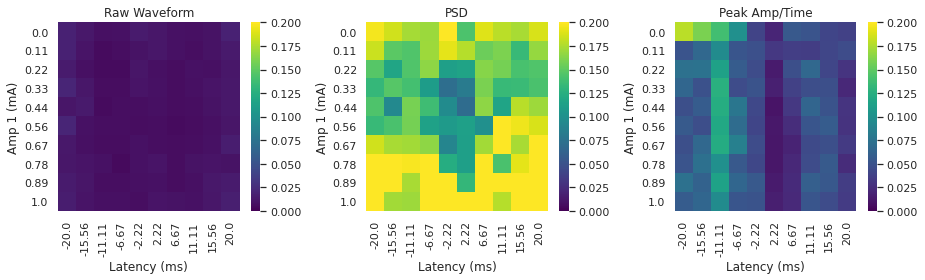

In [78]:
input_type_list = ['raw_waveform_noise', 'psd_noise', 'peak_noise']
param_labels = ['Amp 1 (mA)', 'Amp 2 (mA)', 'Latency (ms)']
plot_labels = ['Raw Waveform', 'PSD', 'Peak Amp/Time']
all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

plt.figure(figsize=(13,4))
for plot_idx, input_type in enumerate(input_type_list):
    x_val = np.load(f'{data_path}/validation_sims/x_{input_type}_validation.npy')
    theta_val = np.load(f'{data_path}/validation_sims/theta_{input_type}_validation.npy')

    rmse_list = list()
    for cond_idx in range(x_cond.shape[0]):
        x_ground_truth = np.tile(x_cond[cond_idx], num_samples).reshape(num_samples,-1)
        x_sampled = x_val[ground_truth_idx==cond_idx, :]
        rmse = np.sqrt(np.mean(np.square(x_sampled - x_ground_truth)))
        rmse_list.append(rmse)

    rmse_array = np.array(rmse_list).reshape(10,10,10)
    xticks = np.round(np.linspace(all_bounds[2][0], all_bounds[2][1], 10), decimals=2)
    yticks = np.round(np.linspace(all_bounds[0][0], all_bounds[0][1], 10), decimals=2)
    
    plt.subplot(1,3,plot_idx+1)
    sns.heatmap(rmse_array[:,5,:], xticklabels=xticks, yticklabels=yticks, vmin=0.0, vmax=0.2, cmap="viridis")
    plt.title(plot_labels[plot_idx])
    plt.xlabel(param_labels[2])
    plt.ylabel(param_labels[0])

plt.tight_layout()